In [1]:
cd ../TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
from TileEM_plot_toolbox import *

Populating the interactive namespace from numpy and matplotlib


In [123]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
DATA_DIR="output"
os.chdir(DATA_DIR)

# Problem: The tiles are not exactly non-overalpping 

## Debugging BB2TileExact 

In [4]:
def overlap(a,b):
    if a.area>b.area:
        larger_area = a.area
    else:
        larger_area = b.area
    return a.intersection(b).area/larger_area

In [84]:
def compute_unique_tileset(tiles):
    duplicate_count = 0
    verified_tiles = []
    for tidx in tqdm(range(len(tiles))): 
        t=tiles[tidx]
        duplicated=False
        for vtidx in range(len(verified_tiles)):
            vt = tiles[vtidx]
            try:
                overlap_score=overlap(vt,t)
                if overlap_score>0.2:
                    print "Duplicate tiles: ",tidx,vtidx, overlap_score
                    duplicate_count+=1
                    duplicated=True
                    if vt.area<t.area:
                        verified_tiles.remove(vt)
                        verified_tiles.append(t)
                    break
            except(shapely.geos.TopologicalError):
                print "Error",tidx,vtidx
        if not duplicated:
            verified_tiles.append(t)
    return verified_tiles

In [6]:
DATA_DIR="outputsample"

In [160]:
def slow_cascaded_union(tiles):
    all_tiles  = copy.deepcopy(tiles)
    Utile=tiles[0]
    all_tiles.remove(tiles[0])
    i=1
    loss_tiles = []
    while(len(all_tiles)>0):
        tile = tiles[i]
        try:
            Utile = Utile.union(tile)
        except(shapely.geos.TopologicalError):
            try:
                Utile =Utile.buffer(0).union(tile.buffer(0))
            except(shapely.geos.TopologicalError):
#                 return tile,Utile 
                #print "Throwing away:", tile.area 
                loss_tiles.append(tile)
        all_tiles.remove(tile)
        i+=1
    try:
        Utile=Utile.union(cascaded_union(loss_tiles))
    except(shapely.geos.TopologicalError):
        try:
            Utile=Utile.buffer(9e-13).union(cascaded_union(loss_tiles).buffer(0))
        except(shapely.geos.TopologicalError):
            loss_area = sum([t.area for t in loss_tiles])
            print "Throwing away:", loss_area
    return loss_tiles,Utile

In [288]:
import copy
objid=10
sampleNworkers=10
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
###################################
tqdm_on=True
save_tiles=False
tiles=[]
if tqdm_on: 
    BB_lst = tqdm(range(len(BB)))
else:
    BB_lst=range(len(BB))
all_tiles=[]
for i in BB_lst:
    bi = BB[i]
    # base case, when i=0, only 2 polygon intersecting
    if i==0:
        tiles.append(bi)
    else: 
        xj_lst = []
        tiles_tmp =copy.deepcopy(tiles)
        for tj in tiles:
            
            try:
                xj=tj.intersection(bi)
                if xj.area>1e-10:# and overlap(xj,tj)<0.2: #eliminating spurious LineString-looking Polygons 
#                     print tj in tiles
#                     print tj in tiles
                    #diff_region = (tj.symmetric_difference(xj)).difference(xj)#.buffer(0)
                    diff_region = tj.difference(xj)
                    if diff_region.area>1e-10:  # If highly overlapping then the differnce would be ~0, don't put in overlapping tiles
                        tiles_tmp.remove(tj)
                        #print "Adding intersection starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,xj)
                        #print "Adding diff_region starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,diff_region)
                        #if xj.intersects(diff_region):
                        if xj.intersection(diff_region).area>1e-8:
                            print "break #1"
                            break
                        #if xj.union(diff_region).area!=tj.area:
                        if not np.isclose(xj.union(diff_region).area,tj.area,rtol=1e-8):
                            print "break#2"
                            print xj.union(diff_region).area
                            print tj.area
                            print xj.union(diff_region).area==tj.area
                            break
                        # check xj and diff region non overlap
                        
                    xj_lst.append(xj)
            except(shapely.errors.TopologicalError):
                xj_lst=xj_lst[:-1]
                pass
        print "tiles:",len(tiles)
        print "tiles_tmp:", len(tiles_tmp)
#         tiles=tiles_tmp[:]
        try:
            Uorig_tiles = cascaded_union(tiles)
            loss_area=0
        except(ValueError):
            loss_tiles,Uorig_tiles=slow_cascaded_union(tiles)
            loss_area = sum([t.area for t in loss_tiles])
        tiles =copy.deepcopy(tiles_tmp)
        try:
#             if loss_area>10:
#                 try:
#                     leftovers = bi.difference(cascaded_union(xj_lst))
#                 except(shapely.errors.TopologicalError):
#                     leftovers = bi.buffer(9e-13).difference(cascaded_union(xj_lst).buffer(0))
#             else:
#             print "Doing conventional diffing for leftovers"
            leftovers = bi.difference(bi.intersection(Uorig_tiles))
            leftovers = leftovers.difference(leftovers.intersection(cascaded_union(xj_lst)))
                
#             if len(tiles)>69 and leftovers.intersection(tiles[69]).area>1e-8:
#                 print "break#3.5"
#                 print leftovers.intersection(cascaded_union(xj_lst)).area
#                 break
            if leftovers.intersection(cascaded_union(xj_lst)).area>1e-6:
                print "pass through break #3"
                print leftovers.intersection(cascaded_union(xj_lst)).area
                break
            if not np.isclose(leftovers.union(cascaded_union(xj_lst)).area,bi.area,rtol=1e-8):
                print "pass through break #4"
                print leftovers.union(cascaded_union(xj_lst)).area - bi.area
#             break
        except(shapely.errors.TopologicalError):
            try: 
                #leftovers = bi.difference(cascaded_union(xj_lst).buffer(1e-10))
                #leftovers = bi.difference(bi.intersection(Uorig_tiles))
                leftovers = bi.difference(bi.intersection(Uorig_tiles.buffer(1e-10)))
                leftovers = leftovers.difference(leftovers.intersection(cascaded_union(xj_lst)))
            except(ValueError):
                loss_tiles,Utile = slow_cascaded_union(xj_lst)
                break
                leftovers=bi.difference(cascaded_union(loss_tiles)).difference(Utile)
                break
        except(ValueError):
            #ERROR:shapely.geos:TopologyException: no outgoing dirEdge 
            leftovers=[]
        #print "Adding leftovers starting: ",len(tiles)
        add_object_to_tiles(tiles,leftovers)
        #print "Finished leftovers starting: ",len(tiles)
    all_tiles.append(tiles)
    uniquify_tiles = compute_unique_tileset(tiles)
    boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
    if not boolean_uniquify_tiles:
        print "BAD: BB",i
        #tiles = uniquify_tiles
        break 
if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))

tiles: 1
tiles_tmp: 4
tiles: 4
tiles_tmp: 14
tiles:

 40%|████      | 4/10 [00:00<00:00, 16.51it/s]

 14
tiles_tmp: 26
tiles:

 26
tiles_tmp: 39
tiles:

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (539.5 264.5, 539.5 264.5) and LINESTRING (539.5 264.5, 539.5 264.5) at 539.5 264.50000000000023
                                                

 39
tiles_tmp: 62
tiles:

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (511.941 234.059, 511.941 234.059) and LINESTRING (511.941 234.059, 511.941 234.059) at 511.94117647058852 234.05882352941188
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (527.207 242.276, 533 246) and LINESTRING (531.12 247.494, 527.207 242.276) at 527.2068965517243 242.27586206896567
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (528.876 244.501, 530.117 246.156) and LINESTRING (531.12 247.494, 527.207 242.276) at 529.54670874713804 245.39561166285074
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.6 266.8, 536.6 266.8) and LINESTRING (538 257, 536.6 266.8) at 536.60000000000002 266.79999999999978
                                               

 62
tiles_tmp: 87
tiles:

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 502.00000000000028 230.92857142857147 at 502.00000000000028 230.92857142857147
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (539.5 264.5, 539.5 264.5) and LINESTRING (539.51 264.448, 539.5 264.5) at 539.50000000000011 264.49999999999983
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (539.5 264.5, 539.5 264.5) and LINESTRING (539.51 264.448, 539.5 264.5) at 539.50000000000011 264.49999999999983
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (502 231, 507.2 232.6) and LINESTRING (502 230.929, 512.625 234.344) at 507.20000000000039 232.60000000000011
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (502 231, 507.2 232.6) and LINESTRING (502 230.929, 512.625 234.344) at 507.20000000000039 232.60000000000011
ERROR:shapely.geos:TopologyExcept

 87
tiles_tmp: 112
tiles:

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (507 232, 502 230.929) and LINESTRING (512.625 234.344, 502 230.929) at 502.00000000000023 230.92857142857147
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (530.182 334.273, 520.368 334.665) and LINESTRING (525.676 334.453, 519.692 334.692) at 523.38761988350427 334.54449520465982
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (530.182 334.273, 520.368 334.665) and LINESTRING (525.676 334.453, 519.692 334.692) at 523.38761988350427 334.54449520465982
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.253 334.11, 530.182 334.273) and LINESTRING (530.182 334.273, 534.253 334.11) at 533.89969980462945 334.12401200781488
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.253 334.11, 530.182 334.273) and LINESTRING (530.182 334.273, 534.253 334.11) a

 112
tiles_tmp: 146
Throwing away:

 233.526590471
tiles:

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 509.93803418803412 232.57521367521366 at 509.93803418803412 232.57521367521366
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (484.613 227.065, 488.652 227.696) and LINESTRING (488.652 227.696, 485 227) at 488.65217391304162 227.69565217391269
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (484.613 227.065, 488.652 227.696) and LINESTRING (488.652 227.696, 485 227) at 488.65217391304162 227.69565217391269
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (535.348 249.174, 535.348 249.174) and LINESTRING (535.348 249.174, 535.348 249.174) at 535.3478260869565 249.17391304347834
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.417 252.166, 535.348 249.174) and LINESTRING (535.348 249.174, 535.348 249.174) at 535.3478260869565 249.17391304

 146
tiles_tmp: 197


ValueError: No Shapely geometry can be created from null value

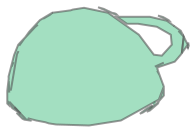

In [166]:
Utile.union(cascaded_union(loss_tiles))

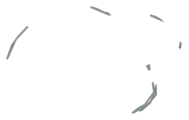

In [165]:
cascaded_union(loss_tiles)

In [159]:
cascaded_union(tiles)

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.426 249.915, 535.052 248.345) and LINESTRING (537.765 255.941, 535.052 248.345) at 535.05172413793105 248.34482758620703


ValueError: No Shapely geometry can be created from null value

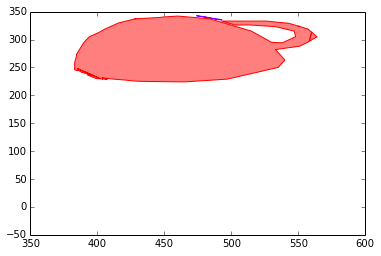

In [153]:
visualizeTilesSeparate([loss_tiles,Utile])

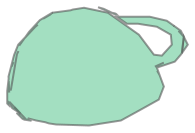

In [158]:
cascaded_union([loss_tiles,Utile])

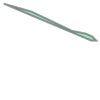

In [151]:
loss_tiles

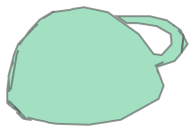

In [152]:
Utile

In [80]:
import mpld3

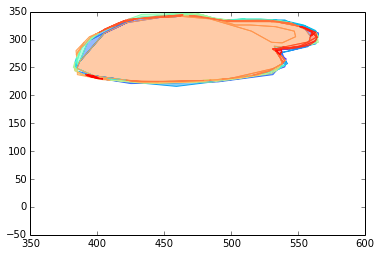

In [125]:
mpld3.enable_notebook()
visualizeTilesSeparate(tiles)

In [96]:
bi.area

15345.0

In [97]:
t_area = [t.area for t in tiles]

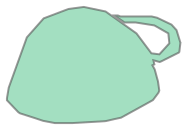

In [99]:
tiles[argmax(t_area)]

In [95]:
sum([t.area for t in tiles])

17726.874015944275

In [86]:
uqtile = compute_unique_tileset(tiles)

In [89]:
len(uqtile)==len(tiles)

True

In [104]:
def visualizeTilesSeparate(tiles,colorful=True):
    plt.figure()
    colors=cm.rainbow(np.linspace(0,1,len(tiles)))
    for t,i in zip(tiles,range(len(tiles))): 
#         plt.figure()
        if colorful: 
            c = colors[i]
        else: 
            c="lime"
        if type(t)==shapely.geometry.polygon.Polygon:
            plot_coords(t,color=c,reverse_xy=True,fill_color=c)
        elif type(t)==shapely.geometry.MultiPolygon or type(t)==shapely.geometry.collection:
            for region in t:
                
                if type(t)!=shapely.geometry.LineString:
                    plot_coords(region,color=c,reverse_xy=True,fill_color=c)

In [130]:
# for i in range(0,4):
#     visualizeTilesSeparate(all_tiles[i],colorful=True)

In [131]:
def compute_verfied_tiles_duplication_rate(tiles):
    duplicate_count = 0
    verified_tiles = []
    for tidx in tqdm(range(len(tiles))): 
        t=tiles[tidx]
        duplicated=False
        for vtidx in range(len(verified_tiles)):
            vt = tiles[vtidx]
            try:
                overlap_score=overlap(vt,t)
                if overlap_score>0.2:
                    print "Duplicate tiles: ",tidx,vtidx, overlap_score
                    duplicate_count+=1
                    duplicated=True
                    break
            except(shapely.geos.TopologicalError):
                print "Error",tidx,vtidx
        if not duplicated:
            verified_tiles.append(t)
    print "Duplication rate: ", duplicate_count/float(len(tiles))
    return verified_tiles

In [287]:
verified_tiles = compute_verfied_tiles_duplication_rate(tiles)

 39%|███▉      | 50/129 [00:00<00:00, 152.85it/s]

Duplicate tiles:  12 1 0.80931112436
Duplicate tiles: 

 58%|█████▊    | 75/129 [00:00<00:00, 88.89it/s] 

 74 19 0.245048936855
Duplicate tiles: 

 78%|███████▊  | 100/129 [00:01<00:00, 69.55it/s]

 86 12 0.401109013658
Duplicate tiles:  101 82 0.393232086534
Duplicate tiles:  104 85 0.240587028067
Duplicate tiles:  105 88 0.474510720937
Duplicate tiles: 

 115 58 0.429429356167
Duplication rate:  0.0542635658915


In [194]:
def visualizeTiles(tiles,colorful=True):
    plt.figure()
    colormap = plt.cm.Paired
    colors = [colormap(i) for i in np.linspace(0, 1,len(tiles))]
    for t,i in zip(tiles,range(len(tiles))): 
        if colorful: 
            c = colors[i]
        else: 
            c="lime"
        if type(t)==shapely.geometry.polygon.Polygon:
            plot_coords(t,color=c,reverse_xy=True)
        elif type(t)==shapely.geometry.MultiPolygon or type(t)==shapely.geometry.collection:
            for region in t:
                if type(t)!=shapely.geometry.LineString:
                    plot_coords(region,color=c,reverse_xy=True)

In [195]:
import mpld3
mpld3.enable_notebook()

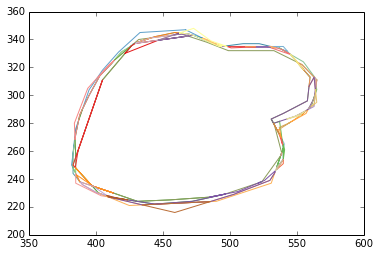

In [196]:
visualizeTiles(verified_tiles)

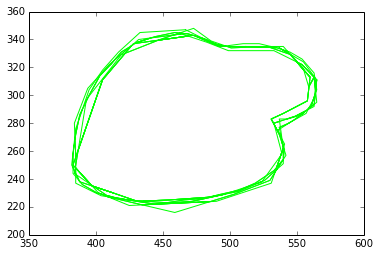

In [182]:
visualizeTiles(tiles)

In [286]:
def BB2TileExact(objid,BB,tqdm_on=False,save_tiles=True):
    tiles=[]
    if tqdm_on: 
        BB_lst = tqdm(range(len(BB)))
    else:
        BB_lst=range(len(BB))
    all_tiles=[]
    for i in BB_lst:
        bi = BB[i]
        # base case, when i=0, only 2 polygon intersecting
        if i==0:
            tiles.append(bi)
        else: 
            xj_lst = []
            tiles_tmp =copy.deepcopy(tiles)
            for tj in tiles:

                try:
                    xj=tj.intersection(bi)
                    if xj.area>1e-10:# and overlap(xj,tj)<0.2: #eliminating spurious LineString-looking Polygons 
                        diff_region = tj.difference(xj)
                        if diff_region.area>1e-10:  # If highly overlapping then the differnce would be ~0, don't put in overlapping tiles
                            tiles_tmp.remove(tj)
                            #print "Adding intersection starting: ",len(tiles)
                            add_object_to_tiles(tiles_tmp,xj)
                            #print "Adding diff_region starting: ",len(tiles)
                            add_object_to_tiles(tiles_tmp,diff_region)
                            if xj.intersection(diff_region).area>1e-8:
                                print "break #1"
                                break
                            if not np.isclose(xj.union(diff_region).area,tj.area,rtol=1e-8):
                                print "break#2"
                                print xj.union(diff_region).area
                                print tj.area
                                print xj.union(diff_region).area==tj.area
                                break
                            xj_lst.append(xj)
                        else:
                            xj_lst.append(tj)
                except(shapely.errors.TopologicalError):
                    print "xj list last item ignored"
                    xj_lst=xj_lst[:-1]
                    pass
    #             try:
    #                 Uorig_tiles = cascaded_union(tiles)
    #                 loss_area=0
    #             except(ValueError):
    #                 print "Used slow cascade union instead"
    #                 loss_tiles,Uorig_tiles=slow_cascaded_union(tiles)
    #                 loss_area = sum([t.area for t in loss_tiles])

            #try:
            print "Bi-(Bi intersect Uorig_tiles)"
            #leftovers = bi.difference(bi.intersection(cascaded_union(tiles))) # causes 2 duplicate tiles
            #leftovers = bi.difference(bi.intersection(cascaded_union(tiles_tmp)))
            leftovers = bi
            for t,tidx in zip(tiles_tmp,range(len(tiles_tmp))): #tiles cause topolgical error
                print tidx
                try:

                    leftovers = leftovers.difference(t)
                    if  type(leftovers)==shapely.geometry.MultiPolygon:
                        for i,l in enumerate(leftovers):
                            if l.area<1e-8:
                                leftovers =leftovers.difference(l)

                except(shapely.geos.TopologicalError):
                    return leftovers,t

    #             except(shapely.errors.TopologicalError): 
    #                 print "diff toplogical error"
    #                 leftovers = bi.difference(bi.intersection(Uorig_tiles.buffer(1e-10)))
    #             except(ValueError):
    #                 print "ValueError"
    #                 leftovers=[]
            tiles =copy.deepcopy(tiles_tmp)
            try:
                print "leftover second step"
                leftovers = leftovers.difference(leftovers.intersection(cascaded_union(xj_lst)))
                if leftovers.intersection(cascaded_union(xj_lst)).area>1e-6:
                    print "pass through break #3"
                    print leftovers.intersection(cascaded_union(xj_lst)).area
    #                     break
                if not np.isclose(leftovers.union(cascaded_union(xj_lst)).area,bi.area,rtol=1e-8):
                    print "pass through break #4"
                    print leftovers.union(cascaded_union(xj_lst)).area - bi.area
    #             except(shapely.errors.TopologicalError):
    #                 leftovers = leftovers.difference(leftovers.intersection(cascaded_union(xj_lst)))
            except(shapely.errors.TopologicalError):
                print "do slow cascade union instead"
                loss_tiles,Utile = slow_cascaded_union(xj_lst)
                leftovers = leftovers.difference(leftovers.intersection(cascaded_union(loss_tiles))).difference(Utile)
        #             break
            print "Adding leftovers starting: ",len(tiles)
            vtiles = compute_verfied_tiles_duplication_rate(tiles)
            add_object_to_tiles(tiles,leftovers)
            print "Finished leftovers starting: ",len(tiles)
        all_tiles.append(tiles)
        uniquify_tiles = compute_unique_tileset(tiles)
        boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
        if not boolean_uniquify_tiles:
            print "BAD: BB",i
            #tiles = uniquify_tiles
    #             return tiles
            break 

    if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))

In [287]:
objid=12
sampleNworkers=-1
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
###################################
tqdm_on=True
save_tiles=False
tiles = BB2TileExact(12,BB,tqdm_on=True,save_tiles=True)
######

# tiles=[]
# if tqdm_on: 
#     BB_lst = tqdm(range(len(BB)))
# else:
#     BB_lst=range(len(BB))
# all_tiles=[]
# for i in BB_lst:
#     bi = BB[i]
#     # base case, when i=0, only 2 polygon intersecting
#     if i==0:
#         tiles.append(bi)
#     else: 
#         xj_lst = []
#         tiles_tmp =copy.deepcopy(tiles)
#         for tj in tiles:

#             try:
#                 xj=tj.intersection(bi)
#                 if xj.area>1e-10:# and overlap(xj,tj)<0.2: #eliminating spurious LineString-looking Polygons 
#                     diff_region = tj.difference(xj)
#                     if diff_region.area>1e-10:  # If highly overlapping then the differnce would be ~0, don't put in overlapping tiles
#                         tiles_tmp.remove(tj)
#                         #print "Adding intersection starting: ",len(tiles)
#                         add_object_to_tiles(tiles_tmp,xj)
#                         #print "Adding diff_region starting: ",len(tiles)
#                         add_object_to_tiles(tiles_tmp,diff_region)
#                         if xj.intersection(diff_region).area>1e-8:
#                             print "break #1"
#                             break
#                         if not np.isclose(xj.union(diff_region).area,tj.area,rtol=1e-8):
#                             print "break#2"
#                             print xj.union(diff_region).area
#                             print tj.area
#                             print xj.union(diff_region).area==tj.area
#                             break
#                         xj_lst.append(xj)
#                     else:
#                         xj_lst.append(tj)
#             except(shapely.errors.TopologicalError):
#                 print "xj list last item ignored"
#                 xj_lst=xj_lst[:-1]
#                 pass
# #             try:
# #                 Uorig_tiles = cascaded_union(tiles)
# #                 loss_area=0
# #             except(ValueError):
# #                 print "Used slow cascade union instead"
# #                 loss_tiles,Uorig_tiles=slow_cascaded_union(tiles)
# #                 loss_area = sum([t.area for t in loss_tiles])

#         #try:
#         print "Bi-(Bi intersect Uorig_tiles)"
#         #leftovers = bi.difference(bi.intersection(cascaded_union(tiles))) # causes 2 duplicate tiles
#         #leftovers = bi.difference(bi.intersection(cascaded_union(tiles_tmp)))
#         leftovers = bi
#         for t,tidx in zip(tiles_tmp,range(len(tiles_tmp))): #tiles cause topolgical error
#             print tidx
#             try:
#                 leftovers = leftovers.difference(t)
#             except(shapely.geos.TopologicalError):
#                 return leftovers,t
            
# #             except(shapely.errors.TopologicalError): 
# #                 print "diff toplogical error"
# #                 leftovers = bi.difference(bi.intersection(Uorig_tiles.buffer(1e-10)))
# #             except(ValueError):
# #                 print "ValueError"
# #                 leftovers=[]
#         tiles =copy.deepcopy(tiles_tmp)
#         try:
#             print "leftover second step"
#             leftovers = leftovers.difference(leftovers.intersection(cascaded_union(xj_lst)))
#             if leftovers.intersection(cascaded_union(xj_lst)).area>1e-6:
#                 print "pass through break #3"
#                 print leftovers.intersection(cascaded_union(xj_lst)).area
# #                     break
#             if not np.isclose(leftovers.union(cascaded_union(xj_lst)).area,bi.area,rtol=1e-8):
#                 print "pass through break #4"
#                 print leftovers.union(cascaded_union(xj_lst)).area - bi.area
# #             except(shapely.errors.TopologicalError):
# #                 leftovers = leftovers.difference(leftovers.intersection(cascaded_union(xj_lst)))
#         except(shapely.errors.TopologicalError):
#             print "do slow cascade union instead"
#             loss_tiles,Utile = slow_cascaded_union(xj_lst)
#             leftovers = leftovers.difference(leftovers.intersection(cascaded_union(loss_tiles))).difference(Utile)
#     #             break
#         print "Adding leftovers starting: ",len(tiles)
#         vtiles = compute_verfied_tiles_duplication_rate(tiles)
#         add_object_to_tiles(tiles,leftovers)
#         print "Finished leftovers starting: ",len(tiles)
#     all_tiles.append(tiles)
#     uniquify_tiles = compute_unique_tileset(tiles)
#     boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
#     if not boolean_uniquify_tiles:
#         print "BAD: BB",i
#         #tiles = uniquify_tiles
# #             return tiles
#         break 

# if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))

Bi-(Bi intersect Uorig_tiles)
0
1
leftover second step
Adding leftovers starting:  2
Duplication rate:  0.0
Finished leftovers starting:  3
Bi-(Bi intersect Uorig_tiles)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
leftover second step
Adding leftovers starting: 

 14
Duplication rate: 

  7%|▋         | 3/41 [00:00<00:02, 15.32it/s]

 0.0
Finished leftovers starting:  15
Bi-(Bi intersect Uorig_tiles)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
leftover second step
Adding leftovers starting: 

 27
Duplication rate: 

 0.0
Finished leftovers starting:  29
Bi-(Bi intersect Uorig_tiles)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
leftover second step
pass through break #4
-16.4398216809


Adding leftovers starting:  45
Duplication rate: 

 0.0
Finished leftovers starting:  47
Bi-(Bi intersect Uorig_tiles)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56

ERROR:shapely.geos:TopologyException: side location conflict at 368 418



57
58
59
60
61
62
leftover second step


ValueError: No Shapely geometry can be created from null value

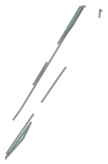

In [275]:
tiles[0]

In [274]:
for t in tiles[0]:
    print t.area

6.6582326288e-14
2.65343302885e-14
1.84542820302e-14
8.2323037276e-14
7.74491581979e-13
9.09494701773e-13
82.8752164979
4.84676140168e-27
3.69482222595e-13
7.95807864051e-13
1.93870456067e-26
14.0
75.9242183177
2.14928075337e-12


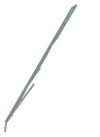

In [277]:
tiles[1]

In [271]:
tiles[0].area

172.79943481551985

In [268]:
tiles[1].area

223.53187481889296

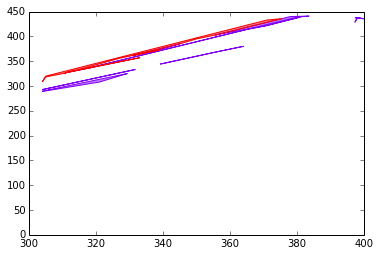

In [266]:
visualizeTilesSeparate(tiles)

In [264]:
tiles[0].difference(tiles[1])

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (311.647 327.882, 311.647 327.882) and LINESTRING (311.647 327.882, 315.476 333.103) at 311.6470588235299 327.88235294117709


TopologicalError: This operation could not be performed. Reason: unknown

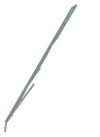

In [262]:
tiles[1]

In [254]:
leftovers

0

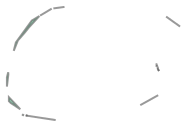

In [244]:
leftovers.difference(t)

In [224]:
compute_verfied_tiles_duplication_rate(leftovers)

Duplication rate:  0.0


In [207]:
vtiles = compute_verfied_tiles_duplication_rate(tiles[:42])

Duplication rate:  0.0


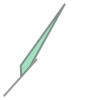

In [176]:
tiles[43]

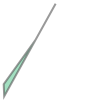

In [177]:
tiles[19]

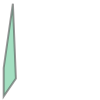

In [121]:
tiles[44]

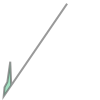

In [116]:
tiles[8]

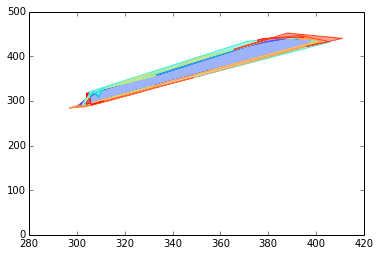

In [112]:
visualizeTilesSeparate(tiles)